In [76]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import data_cleaning as dc
from collections import ChainMap
import seaborn as sns
plt.rcParams['figure.figsize'] = [20, 10]
from random import sample
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing
import xgboost as xgb
from itertools import product

Open Folder containing yaml files and parse each of them, storing the parsed data in a list

In [137]:
#os.chdir('hnd')
#os.getcwd()

In [3]:
matchdata = []

files = [f for f in os.listdir(r'Directory\\The Hundred\\hnd') if f.endswith('.yaml')]

for file in files:
    match = dc.yaml_to_csv(file)
    matchdata.append(match)

To get a list of all players involved, loop through each match and add all player registrys to a list, use ChainMap to create a dictionary of distinct players

In [4]:
playerdicts = []
for match in matchdata:
    players = match[4]['registry']['people']
    playerdicts.append(players)
    
players = dict(ChainMap(*playerdicts[::-1]))

Split match into innings using cleaning function which also adds game and player ids to help with joining

In [5]:
inningslist = []
gameid = 1
for match in matchdata:
    if 'winner' in match[4]['outcome']:
        innings = dc.match_to_innings(match, gameid, players)
        inningslist.extend(innings)
        gameid += 1
all_innings_df = pd.concat(inningslist)

Join players to their batting performances and pivot to get various stats

In [13]:
players_df = pd.DataFrame(players.items(), columns = ['Name', 'Id'])
batting_df = players_df.merge(all_innings_df, left_on='Id', right_on='Batter_id', how='left')
table = pd.pivot_table(batting_df, values=['Runs_off_bat', 'Game_number'], index=['Name', 'Id', 'Gender'], aggfunc={'Runs_off_bat': [np.sum, np.mean, len], 'Game_number':lambda x: len(x.unique())})
table.columns = ['Games_Played', 'Balls_Faced', 'Strike_Rate', 'Total_Runs']
batting_df_grouped = table.reset_index()
batting_df_grouped.set_index('Name')
batting_df_grouped.drop('Id', axis = 1)

,Name,Gender,Games_Played,Balls_Faced,Strike_Rate,Total_Runs
0,A Capsey,female,8,122,1.229508,150.0
1,A Griffiths,female,3,17,0.647059,11.0
2,A Lyth,male,5,38,1.052632,40.0
3,A Shrubsole,female,3,36,1.166667,42.0
4,A Wellington,female,3,14,0.357143,5.0
...,...,...,...,...,...,...
206,TT Beaumont,female,6,144,0.965278,139.0
207,TW Hartley,male,4,27,0.962963,26.0
208,WCF Smeed,male,6,97,1.711340,166.0
209,WG Jacks,male,7,83,1.759036,146.0


We can now plot graphs such as this one displaying batting average against strike rate, I have limited to players who faced more than 15 balls and played more than 5 games. Note I plotted runs per game not Batting Average

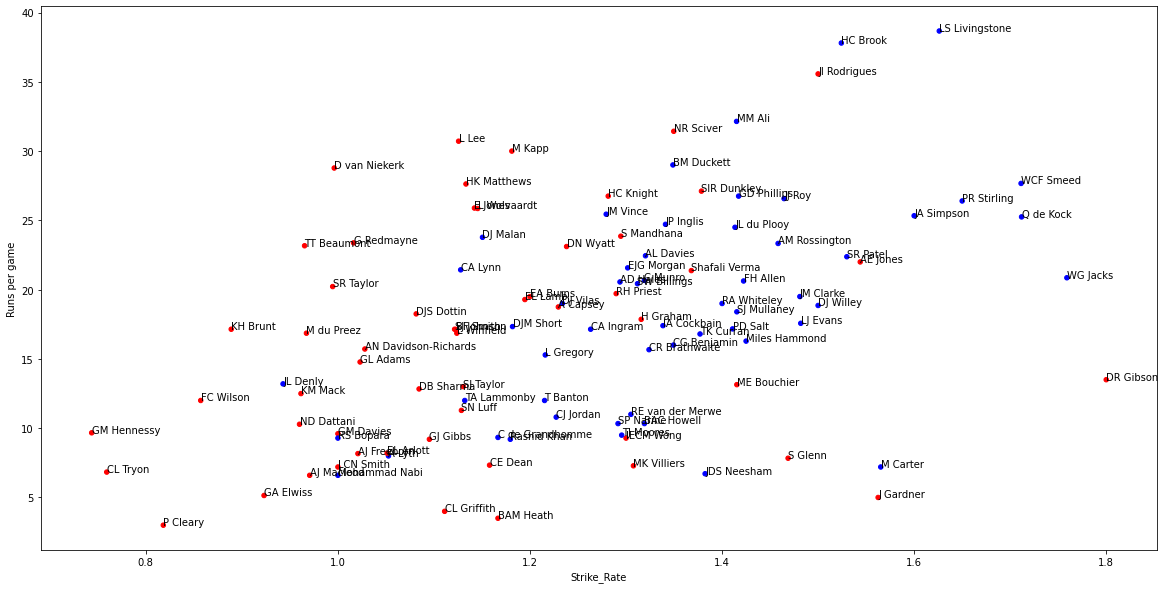

In [139]:
colors = {'female':'red', 'male':'blue'}
filtered = batting_df_grouped[(batting_df_grouped['Balls_Faced'] > 15) & (batting_df_grouped['Games_Played'] > 4)].copy()
filtered['Runs per game'] = filtered['Total_Runs']/filtered['Games_Played']

ax = filtered.plot.scatter(x='Strike_Rate', y='Runs per game', c=filtered['Gender'].map(colors))
for k, v in filtered.iterrows():
    ax.annotate(v['Name'], (v['Strike_Rate'], v['Runs per game']) )

<AxesSubplot:xlabel='Kind_of_wicket'>

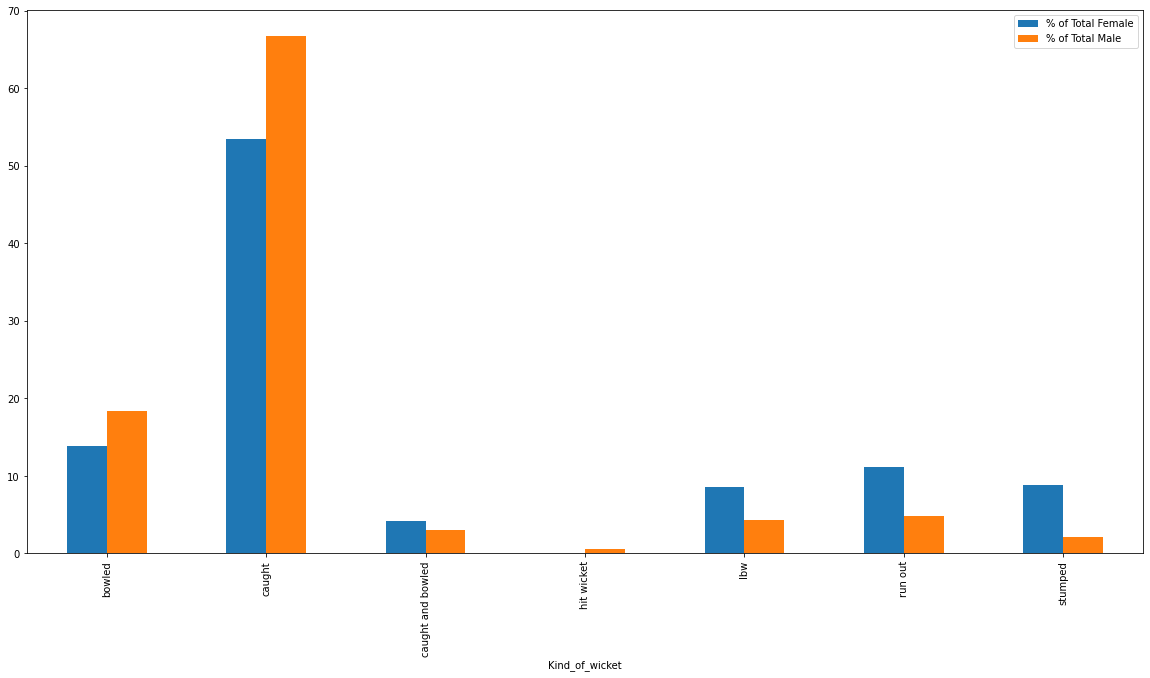

In [18]:
dismissals = batting_df.copy().dropna(subset=['Dismissed_player_id'])
dismissal_types = pd.pivot_table(
    dismissals,
    values = ['Winner'],
    columns = 'Gender',
    index="Kind_of_wicket",
    aggfunc=len
)
dismissal_types.columns = ['female', 'male']
dismissal_types['% of Total Female'] = (dismissal_types.female / dismissal_types.female.sum() * 100)
dismissal_types['% of Total Male'] = (dismissal_types.male / dismissal_types.male.sum() * 100)
dismissal_types[['% of Total Female', '% of Total Male']].plot(kind="bar")

# Modelling expected runs using resoures (balls and wickets remaining)
Here I was experimenting with using machine learning to make a model analogous to DLS

In [24]:
cols = ['Over_and_ball', 'Runs_off_bat', 'Extras', 'Total', 'Kind_of_wicket', 'Game_number', 'Gender', 'Batter_number', 'Innings_number', 'Over', 'Innings_total']
DLS_data = all_innings_df[cols].reset_index()
DLS_data['is_wicket'] = DLS_data.apply(lambda x: bool(x.Kind_of_wicket), axis = 1)
DLS_data['wickets_lost'] = DLS_data.groupby(['Game_number', 'Innings_number'])['is_wicket'].apply(lambda x: x.cumsum())
DLS_data['wickets_remaining'] = DLS_data['wickets_lost'] .apply(lambda x: 10-x)
DLS_data['ball_number'] = DLS_data.sort_values(['Game_number', 'Innings_number', 'Over_and_ball']).groupby(['Game_number', 'Innings_number']).cumcount() + 1
DLS_data['runs_to_be_scored'] = DLS_data.apply(lambda x: x.Innings_total - x.Total, axis = 1)

Function to get balls remaining, this is slightly flawed as a method due to lacking data around which ball in an over was a free hit however should average out over the portfolio, particularly if the dataset is larger

In [25]:
def balls_remaining_hundred(row):
    Over_and_ball = row.Over_and_ball
    Over = row.Over
    Ball = row.ball_number
    ball_of_over = int(math.modf(Over_and_ball)[0]*10)
    if ball_of_over > 5:
        ball_of_over = 5
    balls_remaining = 100 - (Over - 1)*5 - ball_of_over
    return balls_remaining

DLS_data['balls_remaining'] = DLS_data.apply(lambda x: balls_remaining_hundred(x), axis = 1)

DLS_data.head()

,index,Over_and_ball,Runs_off_bat,Extras,Total,Kind_of_wicket,Game_number,Gender,Batter_number,Innings_number,Over,Innings_total,is_wicket,wickets_lost,wickets_remaining,ball_number,runs_to_be_scored,balls_remaining
0,0,0.1,0,0,0,0,1,male,1.0,1,1,145,False,0,10,1,145,99
1,1,0.2,1,0,1,0,1,male,1.0,1,1,145,False,0,10,2,144,98
2,2,0.3,0,0,1,0,1,male,2.0,1,1,145,False,0,10,3,144,97
3,3,0.4,6,0,7,0,1,male,2.0,1,1,145,False,0,10,4,138,96
4,4,0.5,0,0,7,bowled,1,male,2.0,1,1,145,True,1,9,5,138,95


Filtering to the data I need for my model (kept gender in to compare the model for each gender), I then plot a graph of remaining runs scored in the game by balls remaining, with a line for each possible number of wickets remaining, first for mens games and then for womens games.

The data is fairly messy due to being relatively thin, but there is a clear pattern in both graphs that we expect - more resources corresponds to more runs being scored

<AxesSubplot:xlabel='balls_remaining', ylabel='runs_to_be_scored'>

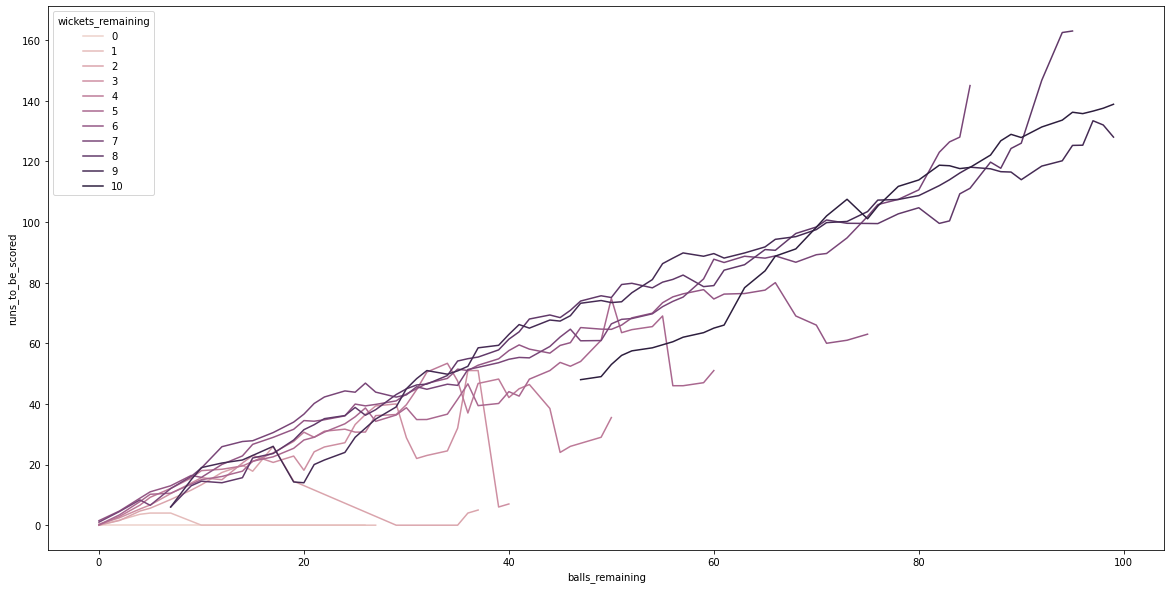

In [34]:
DLS_data_slim = DLS_data[['Total', 'balls_remaining', 'wickets_remaining', 'Innings_total', 'Gender', 'Game_number', 'runs_to_be_scored']]
pivoted_DLS_men = pd.pivot_table(DLS_data_slim[DLS_data_slim['Gender'] == 'male'], values = 'runs_to_be_scored', index = ['balls_remaining', 'wickets_remaining'], aggfunc = np.mean).reset_index()
sns.lineplot(data=pivoted_DLS_men, x='balls_remaining', y='runs_to_be_scored', hue='wickets_remaining', legend = 'full')

<AxesSubplot:xlabel='balls_remaining', ylabel='runs_to_be_scored'>

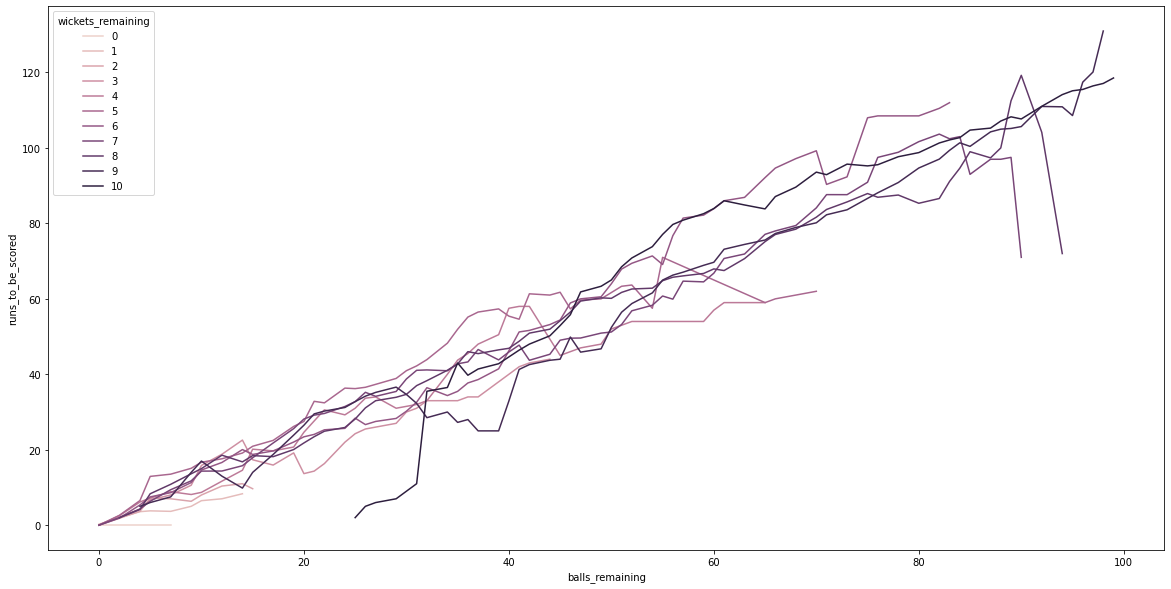

In [35]:
pivoted_DLS_women = pd.pivot_table(DLS_data_slim[DLS_data_slim['Gender'] == 'female'], values = 'runs_to_be_scored', index = ['balls_remaining', 'wickets_remaining'], aggfunc = np.mean).reset_index()
sns.lineplot(data=pivoted_DLS_women, x='balls_remaining', y='runs_to_be_scored', hue='wickets_remaining', legend = 'full')

Inspired by this I thought it would be interesting to see if we could model this, and then apply to each possible combination of balls/wickets remaining to create a prediction of how many runs we would expect a team to score on average. I do not expect this model to be particularly accurate as the variation in results is what makes the game interesting however it may give an idea of what a "par" score might be at a certain point in a game.

As I was not planning on using this model for anything more than interest I haven't used separate test/train sets, and due to the limited games available the model will be severely over fitted to the games I had.

I tried a few different model types and found an xgboost with the parameters below to be the best of those I tried, however I did not spend very long trying different model types.

In [81]:
def build_model(gender: str):
    cols = ['Over_and_ball', 'Runs_off_bat', 'Extras', 'Total', 'Kind_of_wicket', 'Game_number', 'Gender', 'Batter_number', 'Innings_number', 'Over', 'Innings_total']
    final_cols = ['balls_remaining', 'wickets_remaining', 'runs_to_be_scored']
    data = DLS_data_slim[DLS_data_slim['Gender'] == gender]
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(data[final_cols])

    train =  pd.DataFrame(min_max_scaler.transform(data[final_cols]), columns = final_cols)

    X_train = train[['balls_remaining', 'wickets_remaining']]
    Y_train = train['runs_to_be_scored']

    xg_reg = xgb.XGBRegressor(objective ='reg:tweedie', colsample_bytree = 0.3, learning_rate = 0.21, max_depth = 3, alpha = 5, n_estimators = 200)
    
    xg_reg.fit(X_train, Y_train)
    preds = xg_reg.predict(X_train)
    rmse = np.sqrt(MSE(Y_train, preds))
    print(gender + " RMSE : % f" %(rmse))

    return xg_reg, min_max_scaler

In [82]:
mens_model, mens_scaler = build_model('male')
womens_model, womens_scaler = build_model('female')

models = {'male': {'model': mens_model, 'scaler': mens_scaler},
          'female' : {'model': womens_model, 'scaler': womens_scaler}}

male RMSE :  0.095509
female RMSE :  0.091965


In [101]:
balls_remaining_options = list(range(0, 101))
wickets_remaining_options = list(range(0, 11))

scenarios = pd.DataFrame( list(product(balls_remaining_options, wickets_remaining_options)), columns=['balls_remaining', 'wickets_remaining'])

#Adding a column so the scaler works as it expects three columns
scenarios['runs_to_be_scored'] = None
cols = ['balls_remaining', 'wickets_remaining', 'runs_to_be_scored']

In [102]:
def run_model_on_scenarios(gender):
    model = models.get(gender).get('model')
    scaler = models.get(gender).get('scaler')
    scaled = pd.DataFrame(scaler.transform(scenarios), columns = cols)
    predictions_scaled = model.predict(scaled[cols[0:-1]])
    scaled['runs_to_be_scored'] = predictions_scaled
    unscaled = pd.DataFrame(scaler.inverse_transform(scaled), columns = cols)
    return unscaled

In [112]:
def plot_output(gender):
    results = run_model_on_scenarios(gender)
    # Fix scaler rouding error
    results['balls_remaining'] = results['balls_remaining'].apply(lambda x: int(math.floor(x)))
    results['wickets_remaining'] = results['wickets_remaining'].apply(lambda x: int(math.floor(x)))
    pivoted = pd.pivot_table(results, values = ['runs_to_be_scored'], index = ['balls_remaining', 'wickets_remaining'], aggfunc = np.mean).reset_index()
    sns.lineplot(data=pivoted, x='balls_remaining', y='runs_to_be_scored', hue='wickets_remaining', legend = 'full')

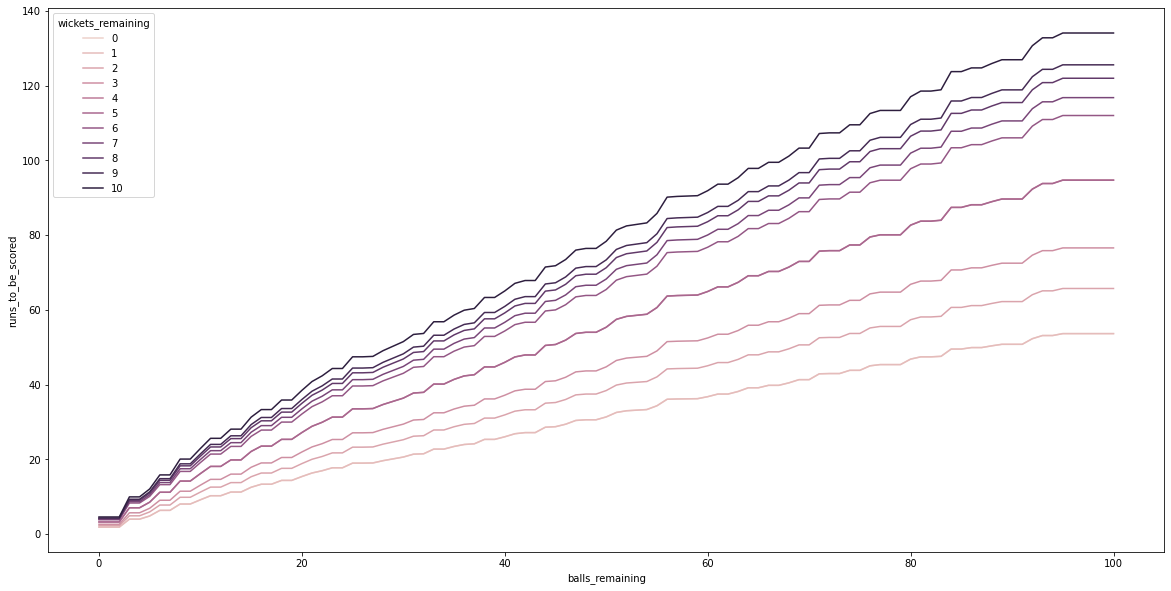

In [113]:
plot_output('male')

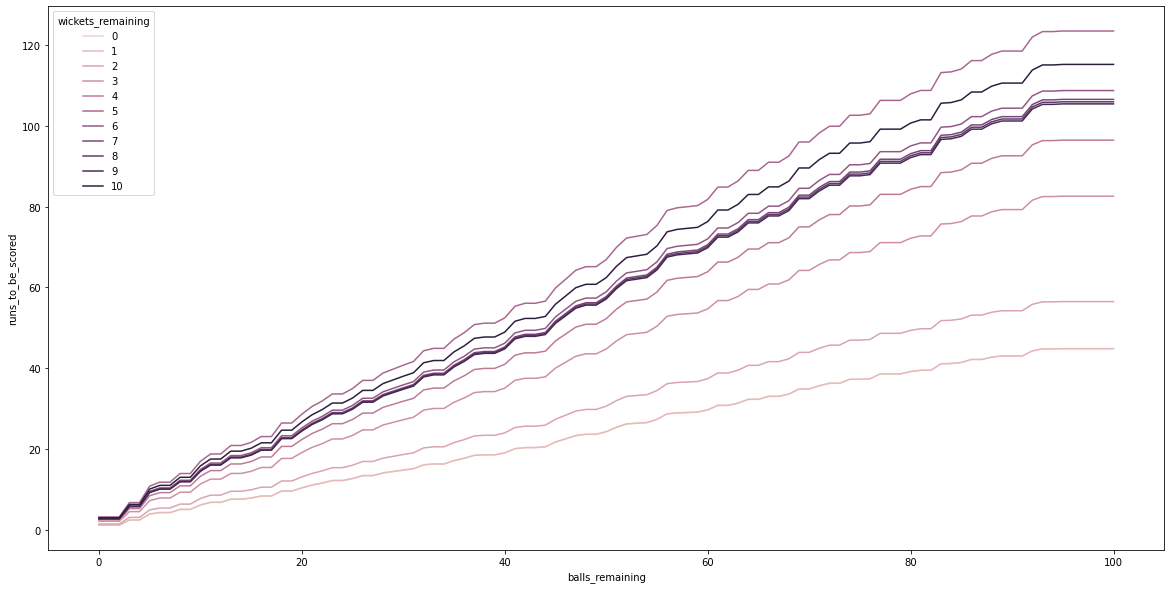

In [111]:
plot_output('female')

Analysis

From this we can see our model gets something similar to what we would expect for the mens game, that expected runs decrease with resources. The curves are not smooth due to the limited data and seriousy overfit model but do not seem to far off what I would expect.

For the womens game we get some strange behaviour where it appears that having six wickets remaining is better than ten. When we compare to the training data we can see that this is due to two innings wheres wickets were lost very quickly, yet a large number of runs were scored. As there were very few innings with this many wicket lost but many balls remaining this appears to have skewed the model to be overfitted to this data point. Options to eliminate this are:
- Wait for more data (which may take some time as this is a rare occurence
- Extrapolate data from where more wickets are remaining
- Only fit each curve where sufficient data at that level of resources exists

Text(0.5, 1.0, 'Outlier Game Plot')

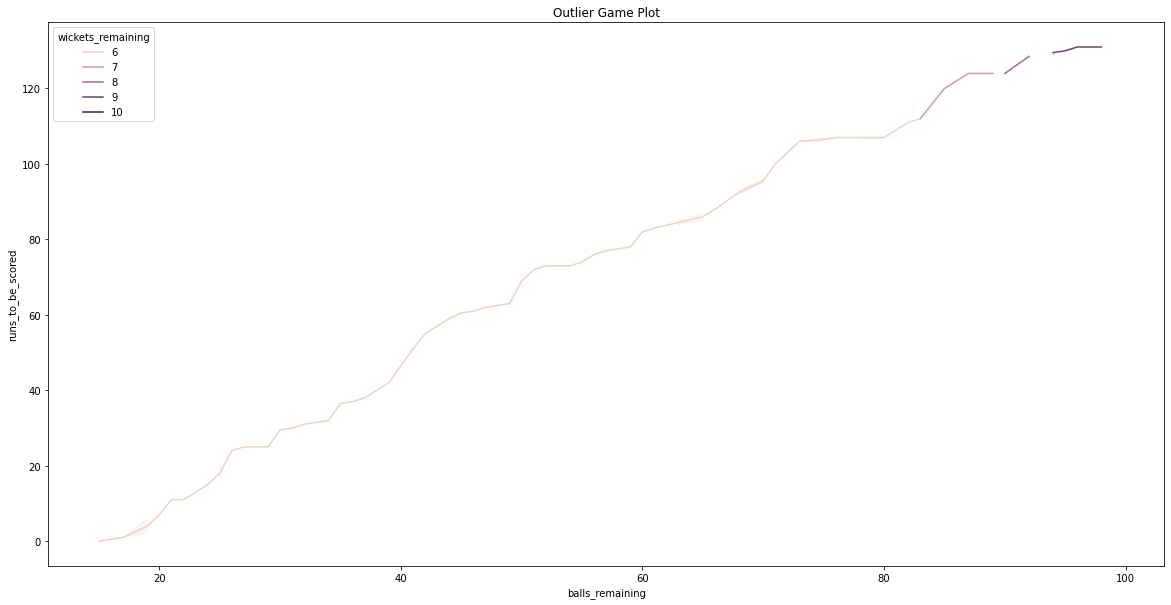

In [135]:
Example1 = DLS_data[(DLS_data['Game_number']==35) & (DLS_data['Innings_number'] == 2)]
sns.lineplot(data=Example1, x='balls_remaining', y='runs_to_be_scored', hue='wickets_remaining', legend = 'full').set_title('Outlier Game Plot')